In [2]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [3]:
house_dataframe=pd.read_csv("california_housing_train.csv", sep=",")

In [4]:
house_dataframe=house_dataframe.reindex(np.random.permutation(house_dataframe.index))
house_dataframe['median_house_value']/=1000.0
house_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features={key:np.array(value) for key,value in dict(features).items()}
    ds=Dataset.from_tensor_slices((features, targets))
    ds=ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds=ds.shuffle(buffer_size=10000)
        
    features, labels=ds.make_one_shot_iterator().get_next()
    return features,labels

In [6]:
my_features=house_dataframe[['total_rooms']]
feature_columns = [tf.feature_column.numeric_column('total_rooms')]
targets=house_dataframe['median_house_value']

my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer=tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

linear_regressor=tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer)
_=linear_regressor.train(input_fn=lambda:my_input_fn(my_features,targets),steps=100)

In [7]:
prediction_input_fn=lambda:my_input_fn(my_features, targets, num_epochs=1, shuffle=False)
predictions=linear_regressor.predict(input_fn=prediction_input_fn)
predictions=np.array([item['predictions'][0] for item in predictions])
mean_squared_error=metrics.mean_squared_error(predictions, targets)
root_mean_squared_error=math.sqrt(mean_squared_error)

In [12]:
print('Mean Squared Error(on training data):{:.3f}'.format(mean_squared_error))
print('Root Mean Squared Error(on training data):{:.3f}'.format(root_mean_squared_error))

Mean Squared Error(on training data):56367.025
Root Mean Squared Error(on training data):237.417


In [13]:
min_house_value=house_dataframe['median_house_value'].min()
max_house_value=house_dataframe['median_house_value'].max()
min_max_difference=max_house_value-min_house_value

print("Min. Median House Value: {:.3f}".format(min_house_value))
print("Max. Median House Value: {:.3f}" .format(max_house_value))
print("Difference between Min. and Max.: {:.3f}" .format(min_max_difference))
print("Root Mean Squared Error: {:.3f}" .format(root_mean_squared_error))

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


In [14]:
house_data=pd.DataFrame()
house_data["predictions"]=pd.Series(predictions)
house_data["targets"]=pd.Series(targets)
house_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


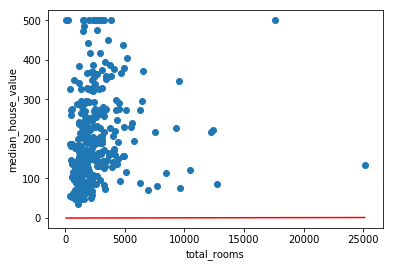

In [17]:
sample = house_dataframe.sample(n=300)
x_0=sample["total_rooms"].min()
x_1=sample["total_rooms"].max()

weight=linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias=linear_regressor.get_variable_value('linear/linear_model/bias_weights')

y_0=weight*x_0 + bias
y_1=weight*x_1 + bias

plt.plot([x_0, x_1],[y_0, y_1], c='r')

plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

plt.scatter(sample['total_rooms'], sample['median_house_value'])

plt.show()